In [1]:
from minimal_model import ref_parameters,  I0, sensitivity_analysis, PARAMETER_NAMES
from minimal_model import perturbation_dynamics, change_parameters, steady_state, I0
import numpy as np
import re

# SOBOL
from SALib.analyze.sobol import analyze
from SALib.sample.sobol import sample

# # RSA
# from SALib.analyze.pawn import analyze
# from SALib.sample.latin import sample

In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator


# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})

# Error bar kwargs for prism style plots
errorbar_kwargs = {'capsize': 2, 'capthick': 1, 'elinewidth': 1, 'zorder': 10}

# Spine properties
spine_properties = {'color': 'black', 'linewidth': 2}

# TODO Better colors for this figure

# Color palate with basal, default, and perturbation colors
colors_basal = ['whitesmoke','lightsteelblue', 'steelblue']

# Color palate default, perturbation
colors_default = ['dimgrey', 'indianred'] 



In [3]:
# Scaling 
# ATP per O2 (3 per O)
PO2 = 5.0
# Whole body oxygen consumption rate ~ 2000 nmol/min/gBW
vO2 = 2000 * 0.7 
# ATP production rate
vATP = PO2 * vO2 
# Scale the oxygen fluxes by vE
vE = vATP 


In [4]:
# Used fited parameters
KI_lipo = 1.3704499219834325
KA_glut4 = 1.0000000000000002
KA_glut_GL = 0.9999999999999996
KI_GL = 0.9999999999999998
KIL = 1.0
KIK = 0.9999999999999999
KF = 1.716778201928797
KG = 15.042598282551413
KFK = 17.239484474797404
KL = 0.37931486897499117
KI_F = 0.010519718694929788
v_in_F = 0.007682129979756625

p_fited = ref_parameters( KI_lipo,  KA_glut4, KA_glut_GL, KIL, KIK, KF, KG, KFK, KL, KI_F,)

In [5]:
# compute sensitivity indices 

SENS_PARAMS  = ["vE", "Imax", "C", "KI_lipo", "KA_glut4", "KF", "KG",
                "omega", "lam", "gamma", 
                "beta", "kappa", "alpha", "VR",
                 "VFK", "KFK", "VLG", "KL", "KI_F", 
                "v0", "rho",]


PATHWAY = {
    "vE":'Energy expenditure',
     "Imax":'Insulin secretion',
     "C":'Insulin secretion',
     "KI_lipo": 'Insulin receptor signaling',
     "KA_glut4": 'Insulin receptor signaling',
     "KF": 'Triglyceride biosynthesis',
     "KG": 'Triglyceride biosynthesis',
    "omega": 'Glucose catabolism',
    "lam": 'Lactate metabolism',
    "gamma": 'Glucose catabolism',
    "beta":  'Fatty acid oxidation',
    "kappa": 'Ketone metabolism',
    "alpha":  'Triglyceride catabolism',
    "VR": 'Triglyceride biosynthesis',
    "VFK": 'Ketone metabolism',
    "KFK":'Ketone metabolism',
    "VLG": 'Lactate metabolism',
    "KL": 'Lactate metabolism',
    "KI_F": 'Insulin receptor signaling',
    "v0":  'Glycogen breakdown',
    "rho": 'Insulin receptor signaling',
}


problem = {
    'groups': [ PATHWAY[s] for s in SENS_PARAMS],
    'num_vars': len(SENS_PARAMS),
    'names': SENS_PARAMS,
    'bounds': [[0, 0.1],]*len(SENS_PARAMS) ,
    'dists': [ 'norm',]*len(SENS_PARAMS) ,
}

# Generate samples
X = sample(problem, 2**16, calc_second_order=False)
X.shape

(786432, 21)

In [6]:
X

array([[ 0.00454251,  0.03175815, -0.03522297, ...,  0.01311907,
        -0.09236823, -0.0274638 ],
       [-0.01603128,  0.03175815, -0.03522297, ...,  0.01311907,
        -0.09236823, -0.0274638 ],
       [ 0.00454251, -0.13155292, -0.12324418, ...,  0.01311907,
        -0.09236823, -0.0274638 ],
       ...,
       [ 0.00454006, -0.13517504,  0.0269496 , ...,  0.05836028,
        -0.00022611,  0.08128562],
       [ 0.00454006, -0.13517504,  0.0269496 , ...,  0.05836028,
        -0.03428398,  0.08128562],
       [-0.19450316, -0.15061937, -0.04899608, ...,  0.10872926,
        -0.03428398,  0.11412866]])

In [7]:
def evaluate(param_values):
    Y = []
    for i,log_rel_values in enumerate(param_values):
        p0 = ref_parameters()
        rel_values = np.exp(log_rel_values)
        values = [p0[PARAMETER_NAMES.index(s)] * r for s,r in zip(SENS_PARAMS,rel_values)]
        p = change_parameters(p0, values, ix=SENS_PARAMS)
        X = steady_state(1.0,p)
        X = np.append(X, X[1] * X[4]/I0)
        X = np.append(X, X[4]/I0 / X[1])
        X[4] = X[4]/I0
        Y.append(X)
    return np.array(Y)
    


In [8]:
# Evaluate parameter variations 
Y = evaluate(X)

In [9]:
def get_unique_in_order(input_list):
    seen = set()
    unique_list = []
    for item in input_list:
        if item not in seen:
            unique_list.append(item)
            seen.add(item)
    return unique_list

UNIQUE_PATHWAYS = get_unique_in_order([ PATHWAY[s] for s in SENS_PARAMS])


In [10]:
# Perform analysis

# Observables
obs = ['Lactate','Glucose', 'Fatty acids','Ketones','Insulin','HOMA-IR', 'HOMA-B']


sensitivity_indices = []
for i in range(7):
    #Si = analyze(problem, X, Y[:,i], S=10) #calc_second_order=False)
    Si = analyze(problem, Y[:,i], calc_second_order=False)
    

    Si = pd.DataFrame(Si)
    Si['MAPPED_TRAIT'] = obs[i]
    Si['Pathway'] = UNIQUE_PATHWAYS
    sensitivity_indices.append(Si)

# Concat into a single Dataframe
df = pd.concat(sensitivity_indices, axis=0)

/Users/dw6835/src/competitive_catabolism/.venv/lib/python3.9/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/dw6835/src/competitive_catabolism/.venv/lib/python3.9/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/dw6835/src/competitive_catabolism/.venv/lib/python3.9/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/dw6835/src/competitive_catabolism/.venv/lib/python3.9/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument tha

In [11]:
df

,S1,S1_conf,ST,ST_conf,MAPPED_TRAIT,Pathway
0,0.047447,0.002448,0.049989,0.000737,Lactate,Energy expenditure
1,0.109245,0.003723,0.113261,0.001661,Lactate,Insulin secretion
2,0.115470,0.003992,0.122823,0.001765,Lactate,Insulin receptor signaling
3,0.050287,0.002689,0.053754,0.000846,Lactate,Triglyceride biosynthesis
4,0.227629,0.005717,0.233408,0.003303,Lactate,Glucose catabolism
...,...,...,...,...,...,...
5,0.001125,0.000354,0.001162,0.000020,HOMA-B,Lactate metabolism
6,0.012116,0.001344,0.013014,0.000230,HOMA-B,Fatty acid oxidation
7,0.000224,0.000173,0.000244,0.000004,HOMA-B,Ketone metabolism
8,0.124241,0.003867,0.131250,0.001754,HOMA-B,Triglyceride catabolism


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_94653/419898710.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, y="MAPPED_TRAIT" ,x='ST', ax=ax,
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_94653/419898710.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, y="MAPPED_TRAIT" ,x='ST', ax=ax,
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_94653/419898710.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, y="MAPPED_TRAIT" ,x='ST', ax=ax,
/var/folders/n5/kq0k2frx0

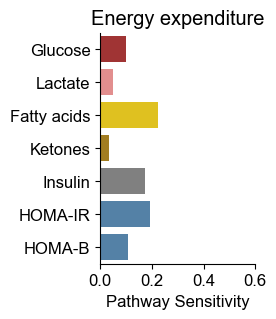

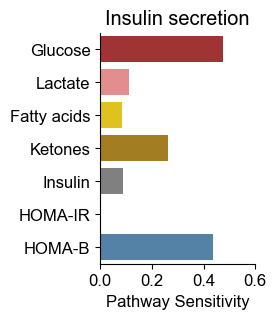

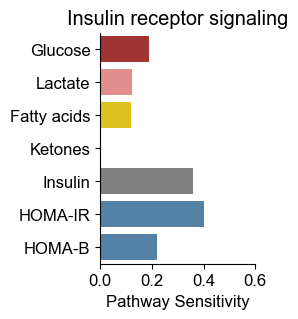

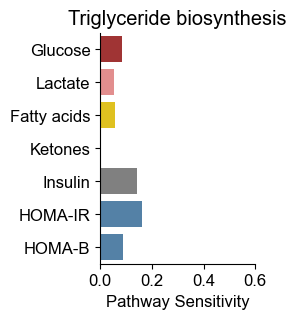

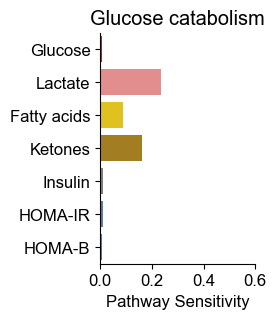

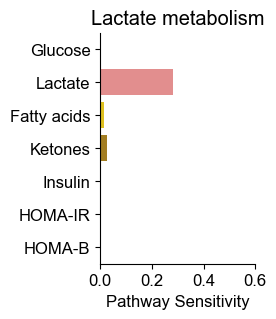

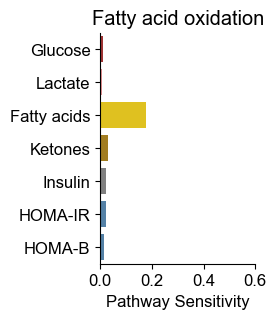

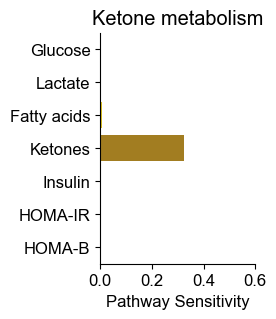

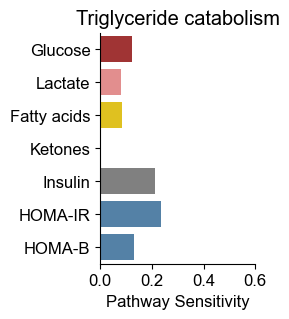

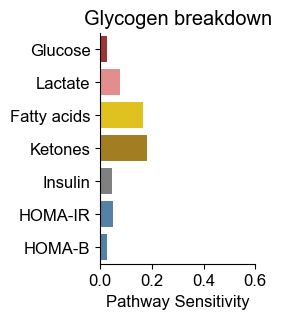

In [12]:

order = ['Glucose', 'Lactate','Fatty acids','Ketones','Insulin', 'HOMA-IR','HOMA-B']

colors_met = ['firebrick', 'lightcoral',  'gold' ,'darkgoldenrod', 'grey' , 'steelblue', 'steelblue']
errorbar_kwargs = {'capsize': 4, 'capthick': 1.5, 'elinewidth': 1.5, 'zorder': 10}


# Make plot for each pathway:
for p in df.Pathway.unique():
    subset = df[(df.Pathway == p)  ].reset_index()

    fig, ax = plt.subplots(1, 1, figsize=(2, 3),)

    sns.barplot(data=subset, y="MAPPED_TRAIT" ,x='ST', ax=ax, 
            palette=colors_met, legend=False, order=order, errorbar=None)
    # Add error bars using the column
#     d = subset.groupby("MAPPED_TRAIT")['S1'].idxmax()
#     d = subset.loc[d.values,:]
#     d.index = d.MAPPED_TRAIT
#     x= d.loc[order,'S1']
#     xerr = d.loc[order,'S1_conf']
#     ax.errorbar(y=order, x=x, xerr=xerr, linestyle='none',color='black',**errorbar_kwargs)

    plt.title(p)

    plt.xlim(0,0.6)

    sns.despine()
    ax.set_xlabel("Pathway Sensitivity")
    ax.set_ylabel("")

    plt.savefig(f"output/trait_effects_{p}.svg", bbox_inches='tight')

In [13]:
df

,S1,S1_conf,ST,ST_conf,MAPPED_TRAIT,Pathway
0,0.047447,0.002448,0.049989,0.000737,Lactate,Energy expenditure
1,0.109245,0.003723,0.113261,0.001661,Lactate,Insulin secretion
2,0.115470,0.003992,0.122823,0.001765,Lactate,Insulin receptor signaling
3,0.050287,0.002689,0.053754,0.000846,Lactate,Triglyceride biosynthesis
4,0.227629,0.005717,0.233408,0.003303,Lactate,Glucose catabolism
...,...,...,...,...,...,...
5,0.001125,0.000354,0.001162,0.000020,HOMA-B,Lactate metabolism
6,0.012116,0.001344,0.013014,0.000230,HOMA-B,Fatty acid oxidation
7,0.000224,0.000173,0.000244,0.000004,HOMA-B,Ketone metabolism
8,0.124241,0.003867,0.131250,0.001754,HOMA-B,Triglyceride catabolism


In [14]:
# Make joint dataframe from all ascocciations: 
# Get all csv files from output 
import os 
import pandas as pd 

data = []
for file_name in os.listdir('./gwas/output'):
    if file_name.endswith('.csv'):
        if not "summary" in file_name:
            the_df = pd.read_csv('./gwas/output/'+file_name, index_col=0)
            data.append(the_df)

df_gwas = pd.concat(data)

df_genes_counts = df_gwas.groupby(['pathway','MAPPED_TRAIT'])[['gene_name','SNPS','PUBMEDID']].nunique(dropna=False).reset_index().fillna(0)

In [15]:
df_gwas.MAPPED_TRAIT.unique()

array(['Insulin', 'Metabolic syndrome', 'Glucose', 'Type 2 diabetes',
       'Lactate', 'Fatty acids', 'Ketones'], dtype=object)

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_94653/1576090436.py:18: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.scatterplot(data=merged_sim_gwas, x='ST', y= 'SNPS', hue='MAPPED_TRAIT', palette=colors_met, hue_order=MAPPED_TRAITS)


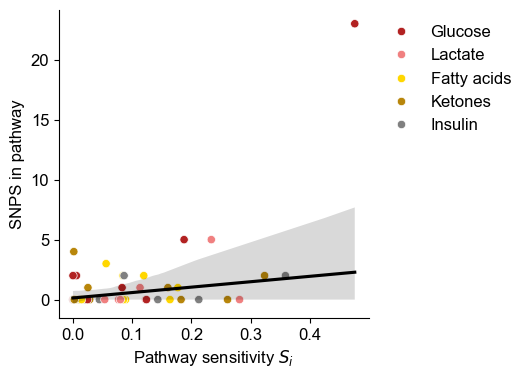

In [16]:
fill_values = {'gene_name':0, 'SNPS': 0 , 'PUBMEDID':0}
merged_sim_gwas = df.merge(df_genes_counts, left_on=['Pathway','MAPPED_TRAIT'], right_on=['pathway','MAPPED_TRAIT'], how='outer').fillna(value=fill_values)


pathways = ['Insulin receptor signaling', 'Insulin secretion',
       'Fatty acid oxidation', 'Glucose catabolism', 'Lactate metabolism',
       'Triglyceride biosynthesis', 'Triglyceride catabolism',
       'Ketone metabolism', 'Glycogen breakdown']

MAPPED_TRAITS = [ 'Glucose',  'Lactate', 'Fatty acids', 'Ketones', 'Insulin',]


merged_sim_gwas = merged_sim_gwas[merged_sim_gwas.Pathway.isin(pathways) & merged_sim_gwas.MAPPED_TRAIT.isin(MAPPED_TRAITS)]


f, ax = plt.subplots(1,1, figsize=(4,4))

sns.scatterplot(data=merged_sim_gwas, x='ST', y= 'SNPS', hue='MAPPED_TRAIT', palette=colors_met, hue_order=MAPPED_TRAITS)
sns.regplot(data=merged_sim_gwas, x='ST', y= 'SNPS',marker='none', color='k', robust=True)


# Legend outside plot no title
plt.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

plt.ylabel("SNPS in pathway")
plt.xlabel("Pathway sensitivity $S_{i}$")
sns.despine()

plt.savefig(f"output/pathway_sensitivity_gwas_correlation_snps.svg", bbox_inches='tight')


In [17]:
from scipy.stats import pearsonr

pearsonr(merged_sim_gwas['SNPS'], merged_sim_gwas['ST'])

PearsonRResult(statistic=0.5635101053109646, pvalue=5.566794995617614e-05)

In [18]:
merged_sim_gwas

,S1,S1_conf,ST,ST_conf,MAPPED_TRAIT,Pathway,pathway,gene_name,SNPS,PUBMEDID
7,0.171360,0.004622,0.177016,0.002577,Fatty acids,Fatty acid oxidation,Fatty acid oxidation,1.0,1.0,2.0
8,0.011648,0.001191,0.012091,0.000178,Glucose,Fatty acid oxidation,NaN,0.0,0.0,0.0
11,0.019170,0.001436,0.021271,0.000372,Insulin,Fatty acid oxidation,NaN,0.0,0.0,0.0
12,0.027315,0.001950,0.028382,0.000361,Ketones,Fatty acid oxidation,NaN,0.0,0.0,0.0
13,0.007319,0.000978,0.007753,0.000128,Lactate,Fatty acid oxidation,NaN,0.0,0.0,0.0
14,0.085689,0.003363,0.088832,0.001143,Fatty acids,Glucose catabolism,NaN,0.0,0.0,0.0
15,0.005749,0.000808,0.005989,0.000078,Glucose,Glucose catabolism,Glucose catabolism,2.0,2.0,3.0
18,0.009555,0.001116,0.010630,0.000193,Insulin,Glucose catabolism,NaN,0.0,0.0,0.0
19,0.153447,0.004501,0.160245,0.002127,Ketones,Glucose catabolism,Glucose catabolism,1.0,1.0,2.0
20,0.227629,0.005717,0.233408,0.003303,Lactate,Glucose catabolism,Glucose catabolism,2.0,5.0,3.0


In [19]:
df_genes_counts

,pathway,MAPPED_TRAIT,gene_name,SNPS,PUBMEDID
0,Fatty acid oxidation,Fatty acids,1,1,2
1,Glucose catabolism,Glucose,2,2,3
2,Glucose catabolism,Ketones,1,1,2
3,Glucose catabolism,Lactate,2,5,3
4,Glucose catabolism,Type 2 diabetes,2,2,4
5,Glycogen breakdown,Type 2 diabetes,1,3,4
6,Insulin receptor signaling,Fatty acids,2,2,1
7,Insulin receptor signaling,Glucose,2,5,5
8,Insulin receptor signaling,Insulin,1,2,2
9,Insulin receptor signaling,Metabolic syndrome,2,4,1
